Reference:
Race simulator for Matlab developed by AJK Phillips, 2014.
Credit to AJK Phillips and http://f1metrics.wordpress.com/

The GitHub link below is from another person who uploaded the code by Phillips, who used to put his MATLAB code on Google Drive. (For more details, check the link below)

https://github.com/syllogismos/F1Sim

# RaceSim

For the simulation to run, we need to define the track variables and the driver variables, and import the data we get from DataAnalysis (i.e. the data from Free Practice(s) and Qualifying) to initialize these variables.



## Track Variables

Track variables include:

- Name
- Number of Laps
- Lap Length
- Race Length
- Tyre variables (provided by Pirelli) 
    - Traction
    - Braking
    - Lateral
    - Tyre Stress
    - Track Evolution
    - Asphalt Grip
    - Asphalt Abrasion
    - Downforce

- Fuel Gain (refer to external sources)
- DNF Factor (The likelihood of retirements as race goes on, this value is compounded by laps elapsed (?))
- Safety Car (SC) variables (Could be extended to VSC)
    - Probability of SC
    - Number of Laps per SC period
    - Laptime of SC
    - Closest time gap between cars during the safety car period
    - Pit Window (Laps for pit window under safety car, i.e. Safety Car Window)
    
- Pit variables
    - In lap time loss
    - Out lap time loss
    
- Racing variables
    - Time gained per lap due to DRS
    - Additional tyre wear (in laps) per lap due to DRS
    - Overtaking variables
        - Distance (in seconds) which the car can follow the closest
        - Time loss (in seconds) due to being overtaken. Does not account for resistance (e.g. blocking or slowing down intentionally)
        - Overtaking Threshold (in seconds), i.e. the time needed to attempt to overtake
        
- Start Time standard deviation (???)

- Time difference between fresh tyre compounds
- Relative wear of different compounds
- Wear factor for track (Can be pulled from Pirelli's infographics)

## Driver Variables

Driver variables include:

- name
- Pit Strategy (Predefined, optional strategy)
- Lap Time Standard Deviation, i.e. the variability of their laptimes
- (For plotting) Driver Team Color

## Race Variables

Race variables include:

- Starting Grid Order
- Teammate pairing (Could be considered as a Driver variable)

#### FP2 and Qualifying Teammates Head-to-Head

In [1]:
import fastf1 as ff1
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from race import *
from qualifying import *
from constants import *
from practice import *
from race_sim import *
from scipy import stats
from scipy.optimize import curve_fit
from prediction import *

# Enable the cache by providing the name of the cache folder
ff1.Cache.enable_cache('cache')

%store -r fp2_race_sim
%store -r times_df

In [2]:
fp2_race_sim

,Driver,MeanLapTime,SpeedFL,SpeedST,Compound,NoOfLaps,LapTimes,LapNumbers
0,HAM,80.853000,253.0,302.0,MEDIUM,1,[80.85300000000001],[2.0]
1,SAI,83.624000,257.0,NaN,MEDIUM,7,"[83.185, 83.22500000000001, 83.44000000000001,...","[12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0]"
2,LEC,83.698286,253.0,303.0,MEDIUM,7,"[83.57400000000001, 83.552, 83.435, 83.4, 83.7...","[10.0, 11.0, 12.0, 13.0, 15.0, 16.0, 17.0]"
3,BOT,83.834000,255.0,305.0,MEDIUM,1,[83.834],[14.0]
4,NOR,83.917429,253.0,306.0,SOFT,7,"[83.25, 83.333, 84.006, 83.667, 84.56700000000...","[7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 14.0]"
5,OCO,84.055000,253.0,304.0,SOFT,1,[84.055],[10.0]
6,VER,84.173000,255.0,305.0,MEDIUM,8,"[83.771, 83.941, 84.012, 84.18100000000001, 84...","[12.0, 13.0, 14.0, 15.0, 16.0, 18.0, 20.0, 22.0]"
7,RIC,84.187333,255.0,304.0,SOFT,6,"[84.21600000000001, 83.796, 84.15400000000001,...","[6.0, 7.0, 8.0, 9.0, 12.0, 13.0]"
8,VET,84.585000,255.0,305.0,MEDIUM,8,"[84.03500000000001, 84.138, 84.71000000000001,...","[11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0]"
9,PER,84.781500,254.0,306.0,MEDIUM,10,"[84.558, 84.578, 84.39, 84.577, 84.727, 84.972...","[11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 19...."


In [3]:
times_df

,Abbreviation,Q1,Q2,Q3,Fastest Lap
63,RUS,78.407,78.154,77.377,77.377
55,SAI,78.434,77.946,77.421,77.421
16,LEC,78.806,77.768,77.567,77.567
4,NOR,78.653,78.121,77.769,77.769
31,OCO,78.866,78.216,78.018,78.018
14,ALO,78.716,77.904,78.078,77.904
44,HAM,78.374,78.035,78.142,78.035
77,BOT,78.935,78.445,78.157,78.157
3,RIC,78.775,78.198,78.379,78.198
1,VER,78.509,77.703,78.823,77.703


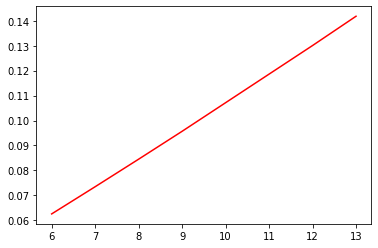

In [4]:
driver = 'RIC'
trackwear = 10

laptimes = fp2_race_sim[fp2_race_sim['Driver'] == driver].LapTimes.tolist()[0]
laps = fp2_race_sim[fp2_race_sim['Driver'] == driver].LapNumbers.tolist()[0]
laptimes = np.array(laptimes)
laps = np.array(laps)




popt, pcov, model = laptime_model(laps, laptimes, trackwear)
plt.plot(laps, model(laps, *popt), 'r-')
plt.show()

In [5]:
teammate_h2h = get_head_to_head_df(fp2_race_sim, times_df)
teammate_h2h

,Driver,GoodFP2,GoodQualifying,Teammate,FP2MeanLapTime,TeammateFP2MeanLapTime,QualifyingLapTime,TeammateQualifyingLapTime,QualifyingPosition,TeammateQualifyingPosition,BaseTime,LongRunEstimate
0,RUS,False,True,HAM,85.315,80.853,77.377,78.035,1,7,85.452722,83.683174
1,SAI,True,True,LEC,83.624,83.698,77.421,77.567,2,3,83.683174,83.705174
2,LEC,True,True,SAI,83.698,83.624,77.567,77.421,3,2,83.808768,83.840971
3,VER,True,True,PER,84.173,84.782,77.703,78.516,10,11,84.181551,84.095363
4,NOR,True,True,RIC,83.917,84.187,77.769,78.198,4,9,84.126123,84.100648
5,ALO,False,True,OCO,85.103,84.055,77.904,78.018,6,5,85.141325,84.210174
6,OCO,False,True,ALO,84.055,85.103,78.018,77.904,5,6,10000.000000,84.324174
7,HAM,False,True,RUS,80.853,85.315,78.035,77.377,7,1,10000.000000,84.341174
8,RIC,True,True,NOR,84.187,83.917,78.198,77.769,9,4,84.420253,84.462214
9,BOT,False,True,ZHO,83.834,85.335,78.157,78.573,8,12,10000.000000,84.463174


In [17]:
# Track data for Hungary
# Can be changed for different tracks

IN_LAP = 2.5
OUT_LAP = 16.5
START_TIME = 6

NO_OF_LAPS = 70

MAX_PIT_TIMES = 6





In [18]:
TYRES = {SOFT, MEDIUM, HARD}
import itertools
combinations = list(itertools.combinations(TYRES, 2))
combinations

[('HARD', 'MEDIUM'), ('HARD', 'SOFT'), ('MEDIUM', 'SOFT')]

In [66]:
# Test: do a 1 stopper strategy first
no_of_stops = 1

long_runs = teammate_h2h.LongRunEstimate.to_numpy()

race_base_times = long_runs * 70 + no_of_stops * (IN_LAP + OUT_LAP+1) + START_TIME

deg_model = np.vectorize(tyre_degradation_model)

min_fastest_time = np.array([99999] * 20)
min_fastest_tyre_combination = np.array(['NA'] * 20,  dtype=object)

for stint_1_laps in range(1, NO_OF_LAPS):
    stint_2_laps =  NO_OF_LAPS - stint_1_laps
    
    
    for combination in combinations:
#         deg_model(np.arange(1, stint_1_laps + 1), combination[0])
        
        run_time = sum(deg_model(np.arange(1, stint_1_laps + 1), combination[0])) + sum(deg_model(np.arange(1, stint_2_laps + 1), combination[1])) + race_base_times
        
        min_fastest_time = np.minimum(run_time, min_fastest_time)
        
        min_fastest_tyre_combination[run_time == min_fastest_time] = '{} {} {} {}'.format(combination[0], stint_1_laps, combination[1], stint_2_laps)
#         print(min_fastest_tyre_combination[run_time == min_fastest_time])

#         min_fastest_time = min(min_fastest_time, min(run_time))
#         min_fastest_tyre_combination = '{} tyre for {} laps, {} tyre for {} laps'.format(combination[0], stint_1_laps, combination[1], stint_2_laps)

print(min_fastest_time)
print(min_fastest_tyre_combination)

[5887.22945101 5888.76945101 5898.27523451 5916.08262939 5916.45264301
 5924.11945101 5932.09945101 5933.28945101 5941.7622061  5941.82945101
 5955.63691951 5966.41698741 5970.94945101 5972.68419451 6010.36804351
 6011.47480708 6012.69343756 6064.99503577 6069.33401001 6102.28302517]
['HARD 49 SOFT 21' 'HARD 49 SOFT 21' 'HARD 49 SOFT 21' 'HARD 49 SOFT 21'
 'HARD 49 SOFT 21' 'HARD 49 SOFT 21' 'HARD 49 SOFT 21' 'HARD 49 SOFT 21'
 'HARD 49 SOFT 21' 'HARD 49 SOFT 21' 'HARD 49 SOFT 21' 'HARD 49 SOFT 21'
 'HARD 49 SOFT 21' 'HARD 49 SOFT 21' 'HARD 49 SOFT 21' 'HARD 49 SOFT 21'
 'HARD 49 SOFT 21' 'HARD 49 SOFT 21' 'HARD 49 SOFT 21' 'HARD 49 SOFT 21']


In [67]:
predicted_results_df = pd.DataFrame(
        columns=['Driver', 'RaceTime', 'Strategy'])

predicted_results_df.Driver = teammate_h2h.Driver
predicted_results_df.RaceTime = min_fastest_time
predicted_results_df.Strategy = min_fastest_tyre_combination

predicted_results_df


,Driver,RaceTime,Strategy
0,RUS,5887.229451,HARD 49 SOFT 21
1,SAI,5888.769451,HARD 49 SOFT 21
2,LEC,5898.275235,HARD 49 SOFT 21
3,VER,5916.082629,HARD 49 SOFT 21
4,NOR,5916.452643,HARD 49 SOFT 21
5,ALO,5924.119451,HARD 49 SOFT 21
6,OCO,5932.099451,HARD 49 SOFT 21
7,HAM,5933.289451,HARD 49 SOFT 21
8,RIC,5941.762206,HARD 49 SOFT 21
9,BOT,5941.829451,HARD 49 SOFT 21
